# Completeness

In [28]:
from lxml import etree
from io import StringIO
import sys, re, os, pdb, pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

root_data_dir = '/Users/lauramiron/Large_files/CTData/'
xml_dir = root_data_dir+'AllPublicXML/'
results_dir = 'results/'
val_results_csv = results_dir+'xml_val_results.csv'

xml_files = [os.path.join(root, f) for root, dirs, files in os.walk(xml_dir) for f in files if f.split('.')[1]=='xml']
NUM_RECORDS = len(xml_files)
print_progress=True

In [4]:
def load_xml(filename_xml):
    with open(filename_xml, 'r') as xml_file:
        xml_to_check = xml_file.read()
    try:
        doc = etree.parse(StringIO(xml_to_check))
        return doc
    except IOError:
        return None
    except etree.XMLSyntaxError as err:
        return None

## Scrape fields from XML records into pandas DataFrames
#### Applicability Info
Create DataFrame of fields from CT.gov records relevant to whether trial is an ACT.  Also get whether trial has any U.S. locations, and the agency class of the lead sponsor.  This dataframe is used in downstream analyses to filter the full set of records down to interventional records, records before and after the effective date of the Final Rule, etc.

In [ ]:
from datetime import datetime
from dateutil.parser import parse

# NOTE: Some records contain dates with no day number, e.g., "January 2017". dateutil parses these by default 
# to the *current* day, causing different results depending on the day of the month the program is run.
# This wrapper functions forces such dates to use the 1st of the month.
def parse_date(date):
    parsed_date = parse(date)
    if ',' not in date:
        return datetime(parsed_date.year,parsed_date.month,1,0,0)
    else: return parsed_date
        

# Return whether start_date of trial record is within (after) the effective date of the Final Rule
# In accordance with FDAAA801, in the absence of the start_date field, use the study_first_submitted field.
def _date_within_final_rule(xml_doc):
    effective_date = parse('January 18, 2017')
    start_elem = xml_doc.find('start_date')
    if start_elem == None: start_elem = xml_doc.find('study_first_submitted')
    start_date = parse_date(start_elem.text)
    if start_date >= effective_date: return True
    else: return False

    
# Make dataframe of fields relevent to where record represents an ACT
def make_applicability_df(outfile='scraped/applicable.p'):
    data = []
    for count, xmlf in enumerate(xml_files,0):
        if (print_progress==True) and (count%10000 == 0): print(f'{count}/{len(xml_files)}')
        xml_doc = load_xml(xmlf)

        # FDAAA801 only applies to interventional trials
        study_type = xml_doc.find('study_type').text
        
        xml_doc = load_xml(xmlf)
        entry = [xmlf.split('/')[-1],study_type]
        if _date_within_final_rule(xml_doc):
            entry.append(True)
        else:
            entry.append(False)
            
        # get overall_status
        elem = xml_doc.find('overall_status')
        if elem is not None: entry.append(elem.text)
        else: entry.append(None)
            
        # get lead sponsor type
        elem = xml_doc.find('sponsors/lead_sponsor/agency_class')
        if elem is not None: entry.append(elem.text)
        else: entry.append(None)
            
        # get us locations
        elems = xml_doc.findall('location/facility/address/country')
        if len(elems)==0: us_locations=None
        else:
            us_locations = False
            for elem in elems:
                if elem.text in ['US','U.S.','United States','us','u.s.']:
                    us_locations = True
        entry.append(us_locations)
            
        # add row to df
        data.append(entry)
    df = pd.DataFrame(data,columns=['filename','study_type','applicable_date','overall_status','lead_sponsor_class','us_locations'])
    df.to_pickle(outfile)
    return df

# uncomment to regenerate applicability dateframe pickle file from raw ClinicalTrials.gov XML files
#df_app = make_applicability_df()

#### Single-occuring elements (all required fields that appear max 1 time per record)

In [ ]:
single_elems = ['filename','official_title','study_design_info/primary_purpose','study_design_info/intervention_model',
                'number_of_arms','study_design_info/allocation','study_design_info/masking',
                'start_date','primary_completion_date','completion_date','enrollment',
                'eligibility/healthy_volunteers','why_stopped','has_expanded_access']


def make_single_elem_df(outfile='scraped/single_required_fields.p'):
    data = []
    for count, xmlf in enumerate(xml_files,0):
        if (print_progress==True) and (count%10000 == 0): print(f'{count}/{len(xml_files)}')
        xml_doc = load_xml(xmlf)
        
        # FDAAA801 only applies to interventional trials
        study_type = xml_doc.find('study_type').text
        if study_type != 'Interventional': continue
        
        entry = [xmlf.split('/')[-1]]
        for elem_name in single_elems[1:]:
            elem = xml_doc.find(elem_name)
            if elem is not None: entry.append(elem.text)
            else: entry.append(None)

        # special scraping rules for 'brief_summary' element because we do not have space to store the whole summary
        summ = xml_doc.find('brief_summary')
        entry.append(summ if summ==None else True)
        data.append(entry)

    df = pd.DataFrame(data,columns=single_elems+['brief_summary'])
    df.to_pickle(outfile)
    return df

# Uncomment to regenerate dataframe from raw XML files
# df_single = make_single_elem_df()
# df_single[0:100]

#### Intervention Information

In [ ]:
def make_intervention_df(filename='intervention.p'):
    data = []
    for count, xmlf in enumerate(xml_files,0):
        if (print_progress==True) and (count % 10000 == 0): print(f'{count}/{len(xml_files)}')
        xml_doc = load_xml(xmlf)

        intervention_elems = xml_doc.findall('intervention')
        if len(intervention_elems)==0:
            data.append([xmlf.split('/')[-1],None,None,None,None,None])
        else:
            for intervention in intervention_elems:
                itype = None if intervention.find('intervention_type') == None else intervention.find('intervention_type').text
                iname = None if intervention.find('intervention_name') == None else intervention.find('intervention_name').text
                description = None if intervention.find('description') == None else intervention.find('description').text
                arm_group_label = None if intervention.find('arm_group_label') == None else intervention.find('arm_group_label').text
                other_name = None if intervention.find('other_name') == None else intervention.find('other_name').text
                data.append([xmlf.split('/')[-1],itype,iname,description,arm_group_label,other_name])
    df = pd.DataFrame(data,columns=['filename','intervention_type','intervention_name','intervention_description','arm_group_label','other_name'])
    df.to_pickle(filename)
    return df

# df_inter = make_intervention_df()
# df_inter[0:100]

#### Outcome Measures

In [ ]:
def make_primary_outcome_df(filename='primary_outcome.p'):
    data = []
    for count, xmlf in enumerate(xml_files,0):
        if (print_progress==True) and (count % 10000 == 0): print(f'{count}/{len(xml_files)}')
        xml_doc = load_xml(xmlf)

        outcome_elems = xml_doc.findall('primary_outcome')
        if len(outcome_elems)==0:
            data.append([xmlf.split('/')[-1],None,None,None])
        else:
            for outcome in outcome_elems:
                measure = None if outcome.find('measure') == None else outcome.find('measure').text
                time_frame = None if outcome.find('time_frame') == None else outcome.find('time_frame').text
                description = None if outcome.find('description') == None else outcome.find('description').text
                data.append([xmlf.split('/')[-1],measure,time_frame,description])
    df = pd.DataFrame(data,columns=['filename','measure','time_frame','description'])
    df.to_pickle(filename)
    return df

# Uncomment to regenerate dataframe from original XML
# df_outcome = make_primary_outcome_df()
# df_outcome[0:50]

#### Facility Information and Contact Information

In [ ]:
def make_overall_contact_df(outfile='scraped/overall_contact.p'):
    overall_contact_elems = ['overall_contact/first_name','overall_contact/middle_name','overall_contact/last_name',
                         'overall_contact/degrees','overall_contact/phone','overall_contact/email']
    data = []
    for count, xmlf in enumerate(xml_files,0):
        if (print_progress==True) and (count%10000 == 0): print(f'{count}/{len(xml_files)}')
        xml_doc = load_xml(xmlf)
        
        if xml_doc.find('overall_contact') is None:
            entry = [xmlf.split('/')[-1], True] + [None for i in range(len(overall_contact_elems))]
        else:
            entry = [xmlf.split('/')[-1], False]
            for oelem in overall_contact_elems:
                value = None if xml_doc.find(oelem) is None else xml_doc.find(oelem).text
                entry.append(value)
        data.append(entry)
    df = pd.DataFrame(data,columns=['filename','no_overall_contact']+overall_contact_elems)
    df.to_pickle(outfile)
    return df

# Uncomment to regenerate dataframe from original XML files
# df_overall = make_overall_contact_df()
# df_overall[0:100]

In [ ]:
def make_facility_df(outfile='scraped/facility.p'):
    location_elem_names = ['facility/name','facility/address/city','facility/address/state','facility/address/zip','facility/address/country',
                      'status','contact/first_name','contact/middle_name','contact/last_name','contact/degrees','contact/phone','contact/phone_ext','contact/email',
                      'contact_backup/first_name','contact_backup/middle_name','contact_backup/last_name','contact_backup/degress','contact_backup/phone','contact_backup/phone_ext','contact_backup/email',
                      'investigator/first_name','investigator/middle_name','investigator/last_name','investigator/degrees','investigator/role','investigator/affiliation']
    data = []
    for count, xmlf in enumerate(xml_files,0):
        if (print_progress==True) and (count%10000 == 0): print(f'{count}/{len(xml_files)}')
        xml_doc = load_xml(xmlf)

        location_elems = xml_doc.findall('location')
        if (location_elems==None) or (len(location_elems)==0):
            entry = [xmlf.split('/')[-1], True] + [None for i in range(len(location_elem_names))]
            data.append(entry)
        for location_elem in location_elems:
            entry = [xmlf.split('/')[-1], False]
            for elem_name in location_elem_names:
                value = None if location_elem.find(elem_name) is None else location_elem.find(elem_name).text
                entry.append(value)
            data.append(entry)
    df = pd.DataFrame(data,columns=['filename','no_locations']+location_elem_names)
    df.to_pickle(outfile)
    return df

# Uncomment to regenerate dataframe from original XML
# df_facility = make_facility_df()
# df_facility[0:100]

In [ ]:
def make_contacts_df(outfile='scraped/contacts.p'):
    data = []
    for count, xmlf in enumerate(xml_files,0):
        if (print_progress==True) and (count%10000 == 0): print(f'{count}/{len(xml_files)}')
        xml_doc = load_xml(xmlf)
        overall_contact = xml_doc.find('overall_contact')
        overall_contact_backup = xml_doc.find('overall_contact_backup')
        for oc_elem, typ in [(overall_contact,'overall'),(overall_contact_backup,'overall_backup')]:
            if oc_elem is not None:
                last_name = None if oc_elem.find('last_name') is None else oc_elem.find('last_name').text
                phone = None if oc_elem.find('phone') is None else oc_elem.find('phone').text
                email = None if oc_elem.find('email') is None else oc_elem.find('email').text
                entry = [xmlf.split('/')[-1],typ,last_name,phone,email]
                data.append(entry)

        location_elems = xml_doc.findall('location')
        for location_elem in location_elems:
            contact_primary_elem = location_elem.find('contact')
            contact_backup_elem = location_elem.find('contact_backup')
            for contact, typ in [(contact_primary_elem,'primary'),(contact_backup_elem,'backup')]:
                if contact is not None:
                    last_name = None if contact.find('last_name') is None else contact.find('last_name').text
                    phone = None if contact.find('phone') is None else contact.find('phone').text
                    email = None if contact.find('email') is None else contact.find('email').text
                    entry = [xmlf.split('/')[-1],typ,last_name,phone,email]
                    data.append(entry)
    df = pd.DataFrame(data,columns=['filename','type','last_name','phone','email'])
    df.to_pickle(outfile)
    return df

# Uncomment to regenerate dataframe from original XML
# df_contacts = make_contacts_df()
# df_contacts[0:100]    

#### Principal Investigator Info

In [ ]:
def _safe_text(root,elem_name):
    elem = root.find(elem_name)
    if elem == None: return None
    else: return elem.text
    
def extract_invest_info(elem):
    first_name = _safe_text(elem,'first_name')
    middle_name = _safe_text(elem,'middle_name')
    last_name = _safe_text(elem,'last_name')
    degrees = _safe_text(elem,'degrees')
    role = _safe_text(elem,'role')
    affiliation = _safe_text(elem,'affiliation')
    return first_name,middle_name,last_name,degrees,role,affiliation

def make_investigators_df(outfile='scraped/investigators.p'):
    data = []
    cols = ['filename','type','first_name','middle_name','last_name','degrees','role','affiliation','title','responsible_party_type']
    for count, xmlf in enumerate(xml_files,0):
        if count % 10000 == 0: print(f'{count}/{len(xml_files)}')
        xml_doc = load_xml(xmlf)

        overall_official = xml_doc.find('overall_official')
        if not overall_official == None:
            first_name,middle_name,last_name,degrees,role,affiliation = extract_invest_info(overall_official)
            data.append([xmlf.split('/')[-1],'overall_official',first_name,middle_name,last_name,degrees,role,affiliation,None])
        
        responsible_invest = xml_doc.find('responsible_party')
        if responsible_invest is not None:
            first_name = None
            middle_name = None
            last_name = _safe_text(responsible_invest,'investigator_full_name')
            degrees = None
            role = None
            affiliation = _safe_text(responsible_invest,'investigator_affiliation')
            title = _safe_text(responsible_invest,'investigator_title')
            rparty_type = _safe_text(responsible_invest,'responsible_party_type')
            data.append([xmlf.split('/')[-1],'responsible_invest',first_name,middle_name,last_name,degrees,role,affiliation,title,rparty_type])
        
        if (overall_official == None) and (responsible_invest==None):
            data.append([xmlf.split('/')[-1],None,None,None,None,None,None,None,None,None])
        
        investigators = xml_doc.findall('location/investigator')
        for invest in investigators:
            first_name,middle_name,last_name,degrees,role,affiliation = extract_invest_info(invest)
            data.append([xmlf.split('/')[-1],'location_investigator',first_name,middle_name,last_name,degrees,role,affiliation,None,None])
                  
    df = pd.DataFrame(data,columns=cols)
    df.to_pickle(outfile)
    return df

# Uncomment to regenerate dataframe from raw XML
# df_invest = make_investigators_df()
# df_invest[0:50]

## Main Completeness Results (Table 5)

In [3]:
df_app = pd.read_pickle('scraped/applicable.p')
filenames_before = df_app[(df_app['applicable_date']==False) & (df_app['study_type']=='Interventional')]['filename']
filenames_after = df_app[(df_app['applicable_date']==True) & (df_app['study_type']=='Interventional')]['filename']
print(f'Found {len(filenames_before)} interventional records with start dates before the effective date of the Final Rule, {len(filenames_after)} interventional records after.')

Found 192985 interventional records with start dates before the effective date of the Final Rule, 46289 interventional records after.


In [5]:
class Solver:
    
    df_single = None
    df_arms = None
    df_intervention = None
    df_outcome = None
    df_facility = None
    df_overall = None
    df_app = None
    filenames_recruiting = []
    filenames_before = []
    filenames_after = []
    filenames_terminated_early = []
    
    def __init__(self):
        self.df_single = pd.read_pickle('scraped/single_required_fields.p')
        self.df_arms = pd.read_pickle('scraped/arm_info.p')
        self.df_intervention = pd.read_pickle('scraped/intervention.p')
        self.df_outcome = pd.read_pickle('scraped/primary_outcome.p')
        self.df_facility = pd.read_pickle('scraped/facility.p')
        self.df_overall = pd.read_pickle('scraped/overall_contact.p')
        self.df_app = pd.read_pickle('scraped/applicable.p')
        self.filenames_recruiting = self.df_app[self.df_app['overall_status']=='Recruiting']['filename'].unique()
        self.filenames_before = self.df_app[(self.df_app['applicable_date']==False) & (self.df_app['study_type']=='Interventional')]['filename']
        self.filenames_after = self.df_app[(self.df_app['applicable_date']==True) & (self.df_app['study_type']=='Interventional')]['filename']
        self.filenames_terminated_early = self.df_app[self.df_app['overall_status'].isin(['Suspended','Terminated','Withdrawn'])]['filename']

    def get_combined_stats(self,app_filenames):
        df_single_app = self.df_single[self.df_single['filename'].isin(app_filenames)]
        df_arms_app = self.df_arms[self.df_arms['filename'].isin(app_filenames)]
        df_intervention_app = self.df_intervention[self.df_intervention['filename'].isin(app_filenames)]
        df_outcome_app = self.df_outcome[self.df_outcome['filename'].isin(app_filenames)]
        df_overall_app = self.df_overall[self.df_overall['filename'].isin(app_filenames)]
        df_facility_app = self.df_facility[self.df_facility['filename'].isin(app_filenames)]
        
        # count missing values for 'single' required fields
        s_nulls_1 = df_single_app.isnull().sum()
        s_nulls_1['why_stopped'] = self.num_records_missing_why_stopped(df_single_app)
        
        # special rules for required elements that can occur multiple times, or are only
        # conditionally required
        nulld = {}
        nulld['arm_information'] = Solver.num_records_missing_arms(df_arms_app)
        nulld['intervention_description'] = Solver.num_records_missing_intervention_description(df_intervention_app)
        nulld['outcomes_missing'] = Solver.num_records_missing_primary_outcomes(df_outcome_app)
        nulld['time_frame_missing'] = Solver.num_records_missing_time_frame(df_outcome_app)
        nulld['outcome_description_missing'] = Solver.num_records_missing_outcome_description(df_outcome_app)
        nulld['indiv_site_status'] = Solver.num_records_missing_site_status(df_facility_app)
        nulld['no_facilities'] = Solver.num_records_missing_facility_info(df_facility_app)
        nulld['broken_facilities'] = Solver.num_records_missing_broken_locations(df_facility_app)
        nulld['contact_info'] = Solver.num_records_bad_contacts(df_overall_app,df_facility_app)
        
        s_nulls_2 = pd.Series(nulld)
        df_nulls = pd.concat([s_nulls_1,s_nulls_2])
        return df_nulls
    
    def num_records_missing_why_stopped(self,df_single):
        return df_single[(df_single['why_stopped'].isnull()) & (df_single['filename'].isin(self.filenames_terminated_early))]['filename'].nunique()
        
    def num_records_missing_arms(df_arms):
        return df_arms[df_arms['arm_group_label'].isnull()]['filename'].nunique()
    
    def num_records_missing_intervention_description(df_inter):
        return df_inter[(df_inter['intervention_type'].notnull()) & (df_inter['intervention_description'].isnull())]['filename'].nunique()
    
    def num_records_missing_primary_outcomes(df_outcome):
        return df_outcome[df_outcome['measure'].isnull()]['filename'].nunique()

    def num_records_missing_time_frame(df_outcome):
        return df_outcome[(df_outcome['measure'].notnull()) & (df_outcome['time_frame'].isnull())]['filename'].nunique()

    def num_records_missing_outcome_description(df_outcome):
        return df_outcome[(df_outcome['measure'].notnull()) & (df_outcome['description'].isnull())]['filename'].nunique()

    def num_records_missing_site_status(df_facility):
        return df_facility[(df_facility['status'].isnull()) & (df_facility['filename'].isin(Solver.filenames_recruiting))]['filename'].nunique()

    def num_records_missing_facility_info(df_facility):
        return df_facility[df_facility['no_locations']==True]['filename'].nunique()

    def num_records_missing_broken_locations(df_facility):
        # We do not consider missing states and zip codes, to avoid incorrectly counting foreign addresses as broken
        return df_facility[(df_facility['no_locations']==False) & ((df_facility['facility/name'].isnull()) | ((df_facility['facility/address/city'].isnull()) | (df_facility['facility/address/country'].isnull())))]['filename'].nunique()

    def num_records_bad_contacts(df_overall,df_facility):
        fnames_no_contact_each_site = df_facility[(df_facility['contact/last_name'].isnull()) | (df_facility['contact/phone'].isnull()) | (df_facility['contact/email'].isnull())]['filename'].unique()
        fnames_no_overall = df_overall[df_overall['no_overall_contact']==True]['filename'].unique()
        return len(set(fnames_no_contact_each_site).intersection(set(fnames_no_overall)))


#### Reproduce Table 5

In [33]:
df_missing.to_csv('results/completeness.csv')

In [18]:
solver = Solver()
total_records = float(len(solver.filenames_before)+len(solver.filenames_after))
df_nulls_before = solver.get_combined_stats(solver.filenames_before).rename('Count Before')
df_nulls_after = solver.get_combined_stats(solver.filenames_after).rename('Count After')
df_combined_pct = pd.Series([(df_nulls_before[i]+df_nulls_after[i])/total_records for i in df_nulls_before.index],index=df_nulls_before.index).rename('Combined Pct')
df_missing = pd.concat([df_nulls_before,df_nulls_after,df_combined_pct],axis=1)
df_missing.style.format({
    'Combined Pct': '{:,.2%}'.format
})

,Count Before,Count After,Combined Pct
filename,0,0,0.00%
official_title,7038,10,2.95%
study_design_info/primary_purpose,8253,6,3.45%
study_design_info/intervention_model,6834,0,2.86%
number_of_arms,23832,296,10.08%
study_design_info/allocation,44552,11938,23.61%
study_design_info/masking,5423,1,2.27%
start_date,2950,3,1.23%
primary_completion_date,15044,0,6.29%
completion_date,13516,21,5.66%


### Detailed Contact Information

In [228]:
def num_records_full_location_contacts(df_facility):
    fnames_no_contact_each_site = df_facility[(df_facility['contact/last_name'].isnull()) | (df_facility['contact/phone'].isnull()) | (df_facility['contact/email'].isnull())]['filename'].unique()
    return df_facility[df_facility['filename'].notin(fnames_no_contact_each_site)]['filename'].nunique()

df_overall = pd.read_pickle('scraped/overall_contact.p')
df_facility = pd.read_pickle('scraped/facility.p')

df_no_overall = df_overall[df_overall['no_overall_contact']==True]
fnames_no_contact_each_site = df_facility[(df_facility['contact/last_name'].isnull())]['filename'].unique()
df_full_facility_contacts = df_facility[~df_facility['filename'].isin(fnames_no_contact_each_site)]
df_no_overall_full_facility = df_full_facility_contacts[df_full_facility_contacts['filename'].isin(df_no_overall['filename'])]

num_no_overall = df_no_overall["filename"].nunique()
num_no_overall_full_facility = df_no_overall_full_facility['filename'].nunique()
print(f'Records with no overall contact: {num_no_overall}')
print(f'Records with no overall contact, but contact for each site: {num_no_overall_full_facility}')

Records with no overall contact: 223468
Records with no overall contact, but contact for each site: 5475


In [6]:
def num_contacts_missing_phone(df_contacts):
    return len(df_contacts[df_contacts['phone'].isnull()])
    
def num_contacts_missing_email(df_contacts):
    return len(df_contacts[df_contacts['email'].isnull()])

df_contacts = pd.read_pickle('scraped/contacts.p')
num_contacts = len(df_contacts)
num_missing_phone = num_contacts_missing_phone(df_contacts)
num_missing_email = num_contacts_missing_email(df_contacts)
print(f'Of {len(df_contacts)} contact details, {num_missing_phone} ({float(num_missing_phone)/num_contacts:.2%}) are missing a phone number and {num_missing_email} ({float(num_missing_email)/num_contacts:.2%}) are missing an email address.')    

Of 385279 contact details, 81195 (21.07%) are missing a phone number and 86611 (22.48%) are missing an email address.


### Principal Investigator

In [5]:
df_invest = pd.read_pickle('scraped/investigators.p')

def evaluate_investigators(df_invest):
    denom = float(df_invest['filename'].nunique())
    print(f'Evaluating {denom} trials')

    df_overall_official = df_invest.loc[(df_invest['type']=='overall_official')]
    num_overall_officials = float(df_overall_official['filename'].count())
    
    df_respons_invest = df_invest.loc[(df_invest['type']=='responsible_invest') & (df_invest['responsible_party_type'].isin(['Principal Investigator','Sponsor-Investigator']))]
    num_respons_invest = df_respons_invest['filename'].nunique()

    df_no_PI = df_invest.loc[~((df_invest['filename'].isin(df_overall_official['filename'])) | (df_invest['filename'].isin(df_respons_invest['filename'])))]
    num_no_PI = df_no_PI['filename'].nunique()
    
    both = set(df_overall_official['filename']).intersection(set(df_respons_invest['filename']))
    num_both = len(both)
    just_overall = set(df_overall_official['filename']) - set(df_respons_invest['filename'])
    num_official_only = len(just_overall)
    just_respons = set(df_respons_invest['filename']) - set(df_overall_official['filename'])
    num_respons_only = len(just_respons)
    
    print(f'{num_no_PI} ({num_no_PI/denom:.2%}) of trials have no PI')
    print(f'{num_official_only} ({num_official_only/denom:.2%}) have only an overall official')
    print(f'{num_respons_only} ({num_respons_only/denom:.2%}) have only a responsible investigator')
    print(f'{num_both} ({num_both/denom:.2%}) have both')

evaluate_investigators(df_invest)

Evaluating 302091.0 trials
35226 (11.66%) of trials have no PI
162985 (53.95%) have only an overall official
22557 (7.47%) have only a responsible investigator
81323 (26.92%) have both


## Completeness Across Industry Sponsors

In [23]:
def make_industry_completeness_df(solver,NIH_filenames,Fed_filenames,industry_filenames,other_filenames):
    nulls_NIH = solver.get_combined_stats(NIH_filenames).rename('NIH') / float(len(NIH_filenames)) *100
    nulls_Fed = solver.get_combined_stats(Fed_filenames).rename('Fed') / float(len(Fed_filenames)) *100
    nulls_industry = solver.get_combined_stats(industry_filenames).rename('Industry') / float(len(industry_filenames)) *100
    nulls_other = solver.get_combined_stats(other_filenames).rename('Other') / float(len(other_filenames)) *100
    return pd.concat([nulls_NIH,nulls_Fed,nulls_industry,nulls_other], axis=1)

In [30]:
df_app = pd.read_pickle('scraped/applicable.p')

NIH_filenames = df_app[(df_app['lead_sponsor_class']=='NIH') & (df_app['study_type']=='Interventional')]['filename']
Fed_filenames = df_app[(df_app['lead_sponsor_class']=='U.S. Fed') & (df_app['study_type']=='Interventional')]['filename']
industry_filenames = df_app[(df_app['lead_sponsor_class']=='Industry') & (df_app['study_type']=='Interventional')]['filename']
other_filenames = df_app[(df_app['lead_sponsor_class']=='Other') & (df_app['study_type']=='Interventional')]['filename']

NIH_filenames_before = set(NIH_filenames).intersection(set(filenames_before))
Fed_filenames_before = set(Fed_filenames).intersection(set(filenames_before))
industry_filenames_before = set(industry_filenames).intersection(set(filenames_before))
other_filenames_before = set(other_filenames).intersection(set(filenames_before))
print(len(NIH_filenames_before),len(Fed_filenames_before),len(industry_filenames_before),len(other_filenames_before))

NIH_filenames_after = set(NIH_filenames).intersection(set(filenames_after))
Fed_filenames_after = set(Fed_filenames).intersection(set(filenames_after))
industry_filenames_after = set(industry_filenames).intersection(set(filenames_after))
other_filenames_after = set(other_filenames).intersection(set(filenames_after))

df = make_industry_completeness_df(solver,NIH_filenames,Fed_filenames,industry_filenames,other_filenames)
df_before = make_industry_completeness_df(solver,NIH_filenames_before,Fed_filenames_before,industry_filenames_before,other_filenames_before)
df_after = make_industry_completeness_df(solver,NIH_filenames_after,Fed_filenames_after,industry_filenames_after,other_filenames_after)

6388 2588 58669 125340


In [31]:
print(f'NIH interventional trials: {len(NIH_filenames)}')
print(f'US Fed interventional trials: {len(Fed_filenames)}')
print(f'Industry interventional trials: {len(industry_filenames)}')
print(f'Other interventional trials: {len(other_filenames)}')

NIH interventional trials: 6851
US Fed interventional trials: 3032
Industry interventional trials: 69100
Other interventional trials: 160291


In [32]:
df.to_csv('results/industry_completeness.csv')
df_before.to_csv('results/industry_completeness_before_FR.csv')
df_after.to_csv('results/industry_completeness_after_FR.csv')
display(df)
display(df_before)
display(df_after)

,NIH,Fed,Industry,Other
filename,0.000000,0.000000,0.000000,0.000000
official_title,6.364034,1.945910,2.594790,2.969599
study_design_info/primary_purpose,1.372062,6.002639,4.612156,2.992058
study_design_info/intervention_model,27.514231,1.912929,2.034732,2.174171
number_of_arms,42.723690,12.302111,11.461650,8.052854
study_design_info/allocation,47.642680,10.883905,22.020260,23.507246
study_design_info/masking,22.069771,1.121372,1.431259,1.802347
start_date,11.137060,2.737467,1.568741,0.638214
primary_completion_date,33.425777,12.961741,7.379161,4.530510
completion_date,21.748650,3.430079,6.745297,4.542987


,NIH,Fed,Industry,Other
filename,0.000000,0.000000,0.000000,0.000000
official_title,6.825297,2.279753,3.054424,3.790490
study_design_info/primary_purpose,1.471509,7.032457,5.432170,3.821605
study_design_info/intervention_model,29.508453,2.241113,2.396496,2.780437
number_of_arms,45.773325,14.412674,13.390377,10.115685
study_design_info/allocation,48.340639,10.278207,20.465663,23.289453
study_design_info/masking,23.669380,1.313756,1.685728,2.304133
start_date,11.944271,3.207110,1.847654,0.813787
primary_completion_date,35.848466,15.185471,8.691132,5.793841
completion_date,23.324984,4.018547,7.939457,5.795436


,NIH,Fed,Industry,Other
filename,0.000000,0.000000,0.000000,0.000000
official_title,0.000000,0.000000,0.009587,0.025750
study_design_info/primary_purpose,0.000000,0.000000,0.000000,0.017167
study_design_info/intervention_model,0.000000,0.000000,0.000000,0.000000
number_of_arms,0.647948,0.000000,0.613556,0.655203
study_design_info/allocation,38.012959,14.414414,30.764069,24.288289
study_design_info/masking,0.000000,0.000000,0.000000,0.002861
start_date,0.000000,0.000000,0.000000,0.008583
primary_completion_date,0.000000,0.000000,0.000000,0.000000
completion_date,0.000000,0.000000,0.028760,0.051501


### Reproduce Figure 1

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


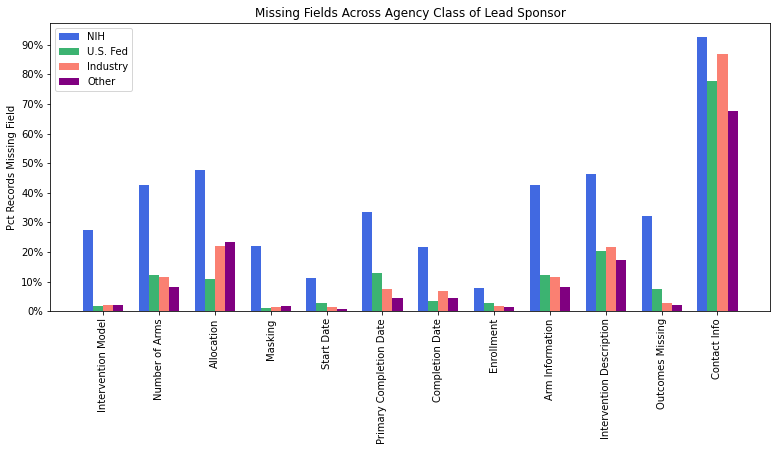

In [29]:
# make histogram
plt_fields = ['study_design_info/intervention_model','number_of_arms','study_design_info/allocation','study_design_info/masking','start_date','primary_completion_date','completion_date','enrollment','arm_information','intervention_description','outcomes_missing','contact_info']
df_ls_plt = df.loc[plt_fields,:]

xlabels = ['Intervention Model','Number of Arms','Allocation','Masking','Start Date','Primary Completion Date','Completion Date','Enrollment','Arm Information','Intervention Description','Outcomes Missing','Contact Info']
num_buckets = len(plt_fields)

X = np.arange(num_buckets)
fig = plt.figure(figsize=(10,4))
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, df_ls_plt['NIH'], color = 'royalblue', width = 0.18)
ax.bar(X + 0.18, df_ls_plt['Fed'], color = 'mediumseagreen', width = 0.18)
ax.bar(X + 0.36, df_ls_plt['Industry'], color = 'salmon', width = 0.18)
ax.bar(X + 0.54, df_ls_plt['Other'], color = 'purple', width = 0.18)

ax.set_ylabel('Pct Records Missing Field')
ax.set_title('Missing Fields Across Agency Class of Lead Sponsor')
ax.set_xticks(X+.27)
ax.set_xticklabels(xlabels,rotation='vertical')

ax.set_yticks(np.arange(0, 100, 10))
vals = ax.get_yticks()
ax.set_yticklabels(['{:}%'.format(x) for x in vals])

ax.legend(labels=['NIH','U.S. Fed','Industry','Other'])
plt.savefig("results/figure2.eps",format='eps',bbox_inches = "tight")
plt.show()

### Completeness Across Trial Locations (Not Included in paper)

In [35]:
us_locs_filenames = df_app[(df_app['us_locations']==True) & (df_app['study_type']=='Interventional')]['filename']
no_us_locs_filenames = df_app[(df_app['us_locations']==False) & (df_app['study_type']=='Interventional')]['filename']
no_locs_filenames = df_app[(df_app['us_locations'].isnull()) & (df_app['study_type']=='Interventional')]['filename']
print(f'Found {len(us_locs_filenames)} interventional trials with at least one US location, {len(no_us_locs_filenames)} without any US locations, and {len(no_locs_filenames)} trials with no listed locations')
print(f'Total: {len(us_locs_filenames)+len(no_us_locs_filenames)+len(no_locs_filenames)}')

Found 100337 interventional trials with at least one US location, 112970 without any US locations, and 25967 trials with no listed locations
Total: 239274


In [36]:
def make_us_locs_completeness_df(solver,us_locs_filenames,no_us_locs_filenames):
    nulls_us_locs = solver.get_combined_stats(us_locs_filenames).rename('us_locations') / float(len(us_locs_filenames)) *100
    nulls_no_us_locs = solver.get_combined_stats(no_us_locs_filenames).rename('no_us_locations') / float(len(no_us_locs_filenames)) *100
    return pd.concat([nulls_us_locs,nulls_no_us_locs], axis=1)

us_locs_filenames_before = set(us_locs_filenames).intersection(set(filenames_before))
no_us_locs_filenames_before = set(no_us_locs_filenames).intersection(set(filenames_before))

us_locs_filenames_after = set(us_locs_filenames).intersection(set(filenames_after))
no_us_locs_filenames_after = set(no_us_locs_filenames).intersection(set(filenames_after))

df = make_us_locs_completeness_df(solver,us_locs_filenames,no_us_locs_filenames)
df_before = make_us_locs_completeness_df(solver,us_locs_filenames_before,no_us_locs_filenames_before)
df_after = make_us_locs_completeness_df(solver,us_locs_filenames_after,no_us_locs_filenames_after)

In [37]:
display(df)
display(df_before)
display(df_after)

df.to_csv('results/location_completeness.csv')
df_before.to_csv('results/location_completeness_before.csv')
df_after.to_csv('results/location_completeness_after.csv')

,us_locations,no_us_locations
filename,0.000000,0.000000
official_title,1.786978,3.471718
study_design_info/primary_purpose,3.167326,3.658493
study_design_info/intervention_model,4.521762,1.342834
number_of_arms,11.763357,8.000354
study_design_info/allocation,28.680347,20.188546
study_design_info/masking,3.477282,1.161370
start_date,1.622532,0.675401
primary_completion_date,6.662547,5.357174
completion_date,5.689825,4.944676


,us_locations,no_us_locations
filename,0.000000,0.000000
official_title,2.169389,4.352562
study_design_info/primary_purpose,3.845130,4.591531
study_design_info/intervention_model,5.489413,1.686118
number_of_arms,14.176649,9.881071
study_design_info/allocation,28.415003,19.409803
study_design_info/masking,4.220206,1.458264
start_date,1.969752,0.848060
primary_completion_date,8.088324,6.726687
completion_date,6.902601,6.200956


,us_locations,no_us_locations
filename,0.000000,0.000000
official_title,0.000000,0.026087
study_design_info/primary_purpose,0.000000,0.008696
study_design_info/intervention_model,0.000000,0.000000
number_of_arms,0.486233,0.643478
study_design_info/allocation,29.920280,23.234783
study_design_info/masking,0.005654,0.000000
start_date,0.000000,0.000000
primary_completion_date,0.000000,0.000000
completion_date,0.022615,0.030435


In [ ]:
def make_condition_csv(outfile='scraped/condition.csv'):
    data = []
    for count, xmlf in enumerate(xml_files):
        if (print_progress==True) and (count%10000 == 0): print(f'{count}/{len(xml_files)}')
        xml_doc = load_xml(xmlf)

        for condition in xml_doc.findall('condition'):
            entry = [xmlf.split('/')[-1],condition.text]
            data.append(entry)
    df = pd.DataFrame(data,columns=['filename','condition'])
    df.to_csv(outfile,sep='\t',header=None)
    return df

# df_condition = make_condition_csv()
# df_condition[0:100]